In [17]:
import autograd.numpy as np
from autograd import grad, jacobian
from scipy.integrate import solve_ivp
from scipy import optimize
import matplotlib.pyplot as plt


In [2]:


# Define HH model parameters
g_Na = 120.0  # Sodium conductance (mS/cm^2)
g_K = 36.0   # Potassium conductance (mS/cm^2)
g_L = 0.3    # Leak conductance (mS/cm^2)
E_Na = 50.0  # Sodium reversal potential (mV)
E_K = -77.0  # Potassium reversal potential (mV)
E_L = -55.0  # Leak reversal potential (mV)
C_m = 1.0    # Membrane capacitance (uF/cm^2)

# Define the HH model equations
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80.0)

# Define the HH model differential equations
def hodgkin_huxley_eq(V, m, h, n, I_params, t):
    I = I_params[0]*np.sin(I_params[1]*t)
    dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return dVdt, dmdt, dhdt, dndt

# Define time parameters
# dt = 0.01  # Time step (ms)
# t = np.arange(0, 50, dt)  # Time vector (ms)
dt = 0.025
t = np.arange(0, 250, dt)


# Initialize state variables
V0 = -65.0  # Membrane voltage (mV)
m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables


In [3]:
def integrate_HH(V0, m, h, n, I_params, dt, t):
    
    V_record = np.zeros_like(t)
    V = V0
    
    for i in range(len(t)):
        V_record[i] = V
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt
    return V_record


    

## Adjoint

### Import Data

In [4]:
import zipfile
import csv

with zipfile.ZipFile('./sim_data/gt_multa.zip', 'r') as zip_ref:
    zip_ref.extractall()
    
with open('gt_multa.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))
    
data_steps = [row[0] for row in data][1:-1] # extract time data
data_steps = np.array([float(i) for i in data_steps]) # convert to numpy array of floats

V_data = [row[1] for row in data][1:-1]
V_data = np.array([float(i) for i in V_data])

I_data = [row[2] for row in data][1:-1]
I_data = np.array([float(i) for i in I_data])

len(V_data)

10000

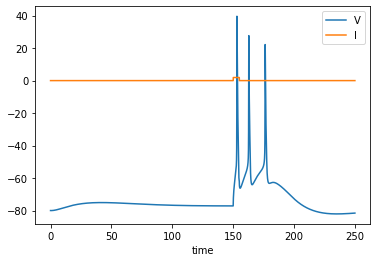

In [5]:
plt.plot(data_steps, V_data, label = 'V')
plt.plot(data_steps, I_data, label = 'I')
plt.xlabel('time')
plt.legend()

#### Fake Data

In [ ]:
# run forward model to create fake data

#A = 4.289
#w = 0.1

A = 4.5
w = 0.1

I_params = np.array([A, w])

V_record = integrate_HH(V0, m, h, n, I_params, dt, t)

I_stimulus = A*np.sin(w*t)

plt.plot(t, V_record, label = 'V')
plt.plot(t, I_stimulus, label = 'I')
plt.xlabel('time')
plt.legend()

In [ ]:
V_subsamp = V_record[::10]
    
mean = np.mean(V_record)
stddev = np.std(V_record)

#noise = np.random.normal(0, stddev, len(V_subsamp))
noise = np.random.normal(0,1,len(V_subsamp))
V_data = V_subsamp + noise

data_steps = t[::10]

In [ ]:
plt.plot(t, V_record, label = 'model equivalent')
plt.plot(data_steps, V_data, label = 'noisy data')
plt.xlabel('time')
plt.ylabel('V')
plt.legend()

### Define cost function

In [7]:
def forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data):

    cost = 0
        
    V_record = []
    V = V0
    
    for i in range(len(t)):
        
        # run forward step
        V_record.append(V)
        
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt

        # compute cost
        if t[i] in data_steps:
            j = np.where(data_steps == t[i])
            cost += (V_record[i] - V_data[j])**2 # [elu(V_record) - elu(V_data)]**2
            
    # cost += l2norm(I)        
    cost = cost/len(data_steps)

            
    #return V_record, cost
    return cost




# look at total cost before any optimization

# first guess
A = 2.0
w = 0.02

I_params = np.array([A, w])

total_cost = forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data)
total_cost       

array([123.53163076])

#### Compute Gradient

In [8]:
# find gradient

grad_AD = grad(forward_model_cost, 0) # 0 indicates differentiation w.r.t. the first argument of f.

In [9]:
# test autograd with I_params used to create fake data

grad_AD(I_params, V0, m, h, n, dt, t, data_steps, V_data)


array([  1.39622899, -99.07369996])

#### FD Check

In [10]:
# # FD check wrt A

# A1 = np.random.uniform(0,5)
# L1 = forward_model_cost(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)

# p = np.random.randint(0,5000)
# s = 1e-7 # step size
# A2 = A1 + s*p
# L2 = forward_model_cost(np.array([A2, w]), V0, m, h, n, dt, t, data_steps, V_data)
# dL_dV_p_diff = (L2 - L1) / s

# g = grad_AD(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)[0]
# dL_dV_p = np.dot(g, p)

# grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
# print('step size=', s, ', gradient finite difference error=', grad_err)


# FD check wrt w

w1 = np.random.uniform(0, 1)
L1 = forward_model_cost(np.array([A, w1]), V0, m, h, n, dt, t, data_steps, V_data)

p = np.random.randint(0,5000)
s = 1e-7 # step size
w2 = w1 + s*p
L2 = forward_model_cost(np.array([A, w2]), V0, m, h, n, dt, t, data_steps, V_data)
dL_dV_p_diff = (L2 - L1) / s

g = grad_AD(np.array([A, w1]), V0, m, h, n, dt, t, data_steps, V_data)[1]
dL_dV_p = np.dot(g, p)

grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
print('step size=', s, ', gradient finite difference error=', grad_err)


step size= 1e-07 , gradient finite difference error= [0.19005641]


step size= 1.0 , example gradient finite difference error= [206218.353362]
step size= 0.1 , example gradient finite difference error= [20611.3050259]
step size= 0.01 , example gradient finite difference error= [2067.03331499]
step size= 0.001 , example gradient finite difference error= [214.1871944]
step size= 0.0001 , example gradient finite difference error= [139.99766361]
step size= 1e-05 , example gradient finite difference error= [36.25609786]
step size= 1e-06 , example gradient finite difference error= [0.13076793]
step size= 1e-07 , example gradient finite difference error= [0.02148116]
step size= 1e-08 , example gradient finite difference error= [0.00225166]
step size= 1e-09 , example gradient finite difference error= [0.00022623]
step size= 1e-10 , example gradient finite difference error= [2.26311354e-05]
step size= 1e-11 , example gradient finite difference error= [2.32382018e-06]
step size= 1e-12 , example gradient finite difference error= [1.06118926e-06]
step size= 1e-13 

Text(0, 0.5, 'error')

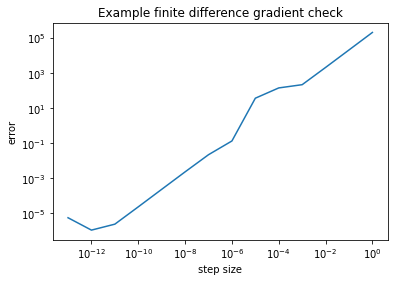

In [11]:
# step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# # Make log-log plot of gradient finite difference error vs. step size

# A1 = np.random.uniform(0,5)
# L1 = forward_model_cost(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)

# # compute gradient using autograd
# g = grad_AD(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)[0]
# dL_dV_p = np.dot(g, p)

# # j = jac_AD(V1, m, h, n, I_stimulus, dt, t, data_steps, V_data)
# # dL_dV_p = np.dot(j, p)


# grad_errs = list()
# for s in step_sizes:
    
#     # compute gradient using finite differences
#     A2 = A1 + s*p

#     L2 = forward_model_cost(np.array([A2, w]), V0, m, h, n, dt, t, data_steps, V_data)
#     dL_dV_p_diff = (L2 - L1) / s


#     # compute gradient error
#     grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
#     print('step size=', s, ', example gradient finite difference error=', grad_err)
    
#     grad_errs.append(grad_err)

# plt.loglog(step_sizes, grad_errs)
# plt.title('Example finite difference gradient check')
# plt.xlabel('step size')
# plt.ylabel('error')




step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# Make log-log plot of gradient finite difference error vs. step size

w1 = np.random.uniform(0, 1)
L1 = forward_model_cost(np.array([A, w1]), V0, m, h, n, dt, t, data_steps, V_data)


# compute gradient using autograd
g = grad_AD(np.array([A, w1]), V0, m, h, n, dt, t, data_steps, V_data)[1]
dL_dV_p = np.dot(g, p)


grad_errs = list()
for s in step_sizes:
    
    # compute gradient using finite differences
    w2 = w1 + s*p

    L2 = forward_model_cost(np.array([A, w2]), V0, m, h, n, dt, t, data_steps, V_data)
    dL_dV_p_diff = (L2 - L1) / s


    # compute gradient error
    grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
    print('step size=', s, ', example gradient finite difference error=', grad_err)
    
    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Example finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')



#### Find Minimizer

In [12]:
A, w

(2.0, 0.02)

In [13]:
# A = 4.289
# w = 0.1


#initial_guess = np.array([4.0, w])
initial_guess = np.array([A, w])

optim = optimize.minimize(forward_model_cost, initial_guess, args = (V0, m, h, n, dt, t, data_steps, V_data), 
                  jac = grad_AD, method = 'Nelder-Mead')#'BFGS')


optim


/Users/shoshi/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:550: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


 final_simplex: (array([[-7.53730263,  0.03280554],
       [-7.53721254,  0.03280553],
       [-7.53732138,  0.03280541]]), array([85.59394372, 85.59394372, 85.59394373]))
           fun: 85.59394372155815
       message: 'Optimization terminated successfully.'
          nfev: 92
           nit: 47
        status: 0
       success: True
             x: array([-7.53730263,  0.03280554])

In [14]:
optim.x

array([-7.53730263,  0.03280554])

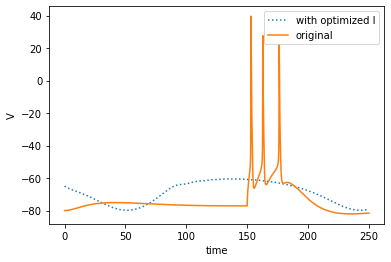

In [16]:
# norm_g = np.linalg.norm(g_func(Ak))
# print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0) # should be less than 1e-6

V_final = integrate_HH(V0, m, h, n, optim.x, dt, t)

plt.figure()
plt.plot(t, V_final, ls = 'dotted', label = 'with optimized I')
#plt.plot(V_record, label = 'original')
plt.plot(t, V_data, label = 'original')
#plt.title('V (steepest descent)')
plt.xlabel('time')
plt.ylabel('V')
plt.legend()

In [ ]:
dt, len(t)

In [ ]:
dt, t

In [ ]:
len(np.arange(0, 250, dt))